## Install Dependencies

In [2]:
# !pip install --upgrade torchcodec
# !pip install torch torchaudio --upgrade
# !pip install transformers datasets evaluate jiwer
# !pip install peft
# !pip install accelerate
# !pip install sentencepiece
# !pip install soundfile
# !pip install librosa
# !pip install tqdm
# !pip install pandas numpy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 70.6 MB/s eta 0:00:00


## Evaluate Untuned Whisper-Small on unseen somali sata

In [1]:
# Install required packages (if needed)
# !pip install -q transformers datasets jiwer torchaudio accelerate

import torch
from datasets import load_dataset, Audio
from transformers import WhisperProcessor, WhisperForConditionalGeneration, pipeline
from jiwer import wer, cer

# -------- CONFIG ----------
MODEL_NAME = "openai/whisper-small"
LANGUAGE = "so"

DATASETS = [
    ("adityaedy01/somali-voice", "sentence"),      # dataset_id, reference column
    ("nurfarah57/somali_asr", "transcription"),
]
BATCH_SIZE = 4
# --------------------------

# Device
device = 0 if torch.cuda.is_available() else -1
print("Device for inference:", ("cuda:0" if device == 0 else "cpu"))

# Load processor & model
processor = WhisperProcessor.from_pretrained(MODEL_NAME, language=LANGUAGE, task="transcribe")
model = WhisperForConditionalGeneration.from_pretrained(MODEL_NAME)

# Build ASR pipeline
asr = pipeline(
    "automatic-speech-recognition",
    model=model,
    tokenizer=processor.tokenizer,
    feature_extractor=processor.feature_extractor,
    device=device,
    chunk_length_s=30
)

def evaluate_dataset(dataset_id: str, text_column: str, batch_size: int):
    """Evaluate Whisper on the full dataset."""
    print(f"\n=== Loading dataset {dataset_id} ===")
    ds = load_dataset(dataset_id, split="train")
    ds = ds.cast_column("audio", Audio(sampling_rate=16000))

    def transcribe_batch(batch):
        audios = [a["array"] for a in batch["audio"]]
        preds = asr(audios)
        if isinstance(preds, dict):  # single sample case
            preds = [preds]
        batch["prediction"] = [p.get("text", "").strip() for p in preds]
        return batch

    print("Running transcription...")
    ds = ds.map(transcribe_batch, batched=True, batch_size=batch_size)

    refs = [str(t).lower().strip() for t in ds[text_column]]
    hyps = [t.lower().strip() for t in ds["prediction"]]

    dataset_wer = wer(refs, hyps)
    dataset_cer = cer(refs, hyps)

    print("\n=== Results for", dataset_id, "===")
    print("Samples evaluated:", len(refs))
    print("WER:", dataset_wer)
    print("CER:", dataset_cer)

    print("\n=== Transcriptions ===")
    for i, (r, h) in enumerate(zip(refs, hyps)):
        print(f"[{i+1}] REF: {r}")
        print(f"    HYP: {h}")
        print("    ---")

    return {"refs": refs, "hyps": hyps, "wer": dataset_wer, "cer": dataset_cer}

# ---- Run evaluation ----
results = {}
for ds_id, text_col in DATASETS:
    results[ds_id] = evaluate_dataset(ds_id, text_col, batch_size=BATCH_SIZE)


Device for inference: cuda:0


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Device set to use cuda:0
Using `chunk_length_s` is very experimental with seq2seq models. The results will not necessarily be entirely accurate and will have caveats. More information: https://github.com/huggingface/transformers/pull/20104. Ignore this warning with pipeline(..., ignore_warning=True). To use Whisper for long-form transcription, use rather the model's `generate` method directly as the model relies on it's own chunking mechanism (cf. Whisper original paper, section 3.8. Long-form Transcription).



=== Loading dataset adityaedy01/somali-voice ===
Running transcription...


Map:   0%|          | 0/2 [00:00<?, ? examples/s]

Using custom `forced_decoder_ids` from the (generation) config. This is deprecated in favor of the `task` and `language` flags/config options.
Transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English. This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`. See https://github.com/huggingface/transformers/pull/28687 for more details.



=== Results for adityaedy01/somali-voice ===
Samples evaluated: 2
WER: 1.0909090909090908
CER: 0.9666666666666667

=== Transcriptions ===
[1] REF: geed gaab iyo geed qodaxeed
    HYP: get up, your gate called ahead.
    ---
[2] REF: laba iyo lixdan laxaad oo dhalaya
    HYP: لَبَئِي اللِّهِدَنُ الْحَادَ وَدَرَيَّعَ
    ---

=== Loading dataset nurfarah57/somali_asr ===


README.md:   0%|          | 0.00/317 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/1.41M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3 [00:00<?, ? examples/s]

Running transcription...


Map:   0%|          | 0/3 [00:00<?, ? examples/s]


=== Results for nurfarah57/somali_asr ===
Samples evaluated: 3
WER: 1.0
CER: 0.6981132075471698

=== Transcriptions ===
[1] REF: geelka waa jaalo.
    HYP: دیل کا آجالہ
    ---
[2] REF: geedkaas waa qurac.
    HYP: kitkas wa quraq.
    ---
[3] REF: lis caanaha geel.
    HYP: لس عانة هجيلة
    ---


## EDA


Dataset: SOMALI_TTS
Total samples: 1719

Text length stats:
count    1719.000000
mean       58.639907
std        31.132225
min         3.000000
25%        39.000000
50%        53.000000
75%        69.000000
max       175.000000
Name: text_length, dtype: float64


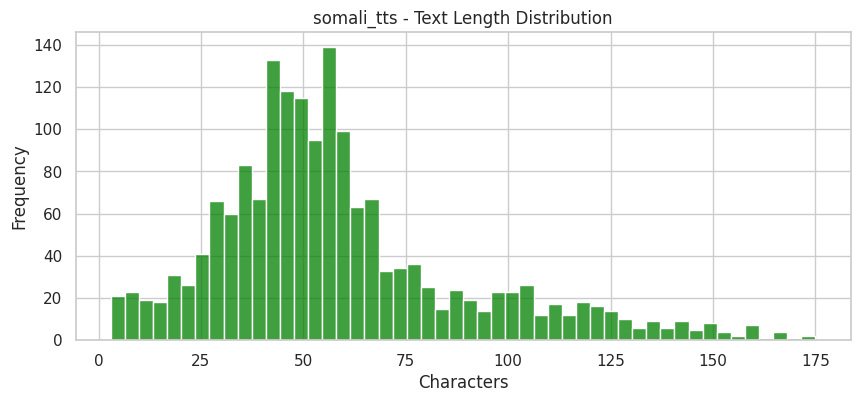


Sample text entries (5):
['Adeegsiga_saabuunta_wanaagsan_waxay_caawisaa_fayodhowrk', 'Fadlan su’aasha ku celi', 'Fasalka dhexdiisa macallinku wuxuu sharxayaa cashar xiiso badan ardayduna si fiican ayay u dhageysanayaan', 'Ha ilaawin inaad maareeyso waqtigaaga', 'Mustaqbalkaagu waa ifaya ee Kaliya ha quusan']

Analyzed 200 audio files (missing: 0)

Audio duration stats (seconds):
count    200.000000
mean       4.395024
std        2.026003
min        0.709320
25%        3.068656
50%        4.054683
75%        5.315340
max       11.373333
dtype: float64

Sample rate distribution:
44100    200
Name: count, dtype: int64


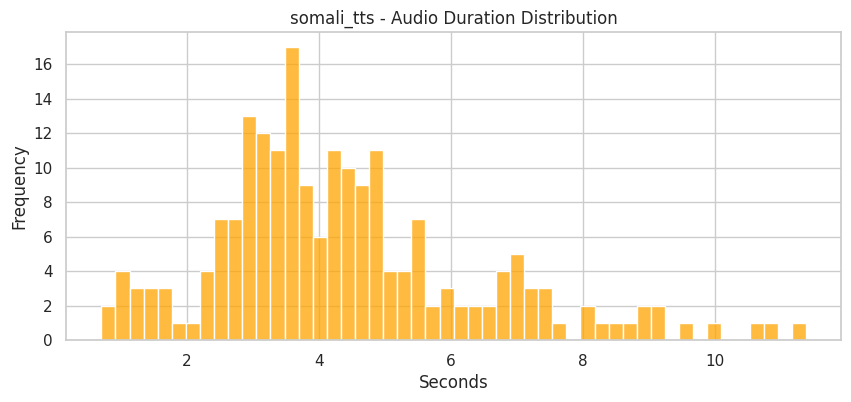


Dataset: SOOMALI_ASR
Total samples: 4999

Text length stats:
count    4999.000000
mean       14.011402
std        10.325246
min         2.000000
25%         7.000000
50%        11.000000
75%        18.000000
max       218.000000
Name: text_length, dtype: float64


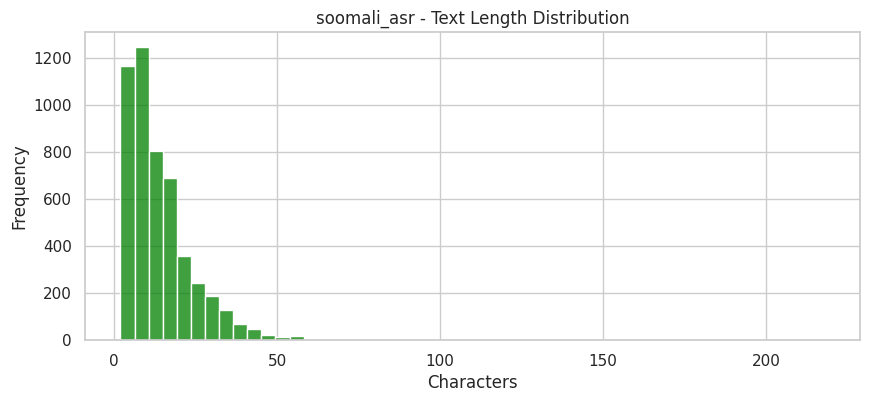


Sample text entries (5):
['ishiisii', 'niman', 'Waa la dhisay.', 'liin', 'tuugada']

Analyzed 200 audio files (missing: 0)

Audio duration stats (seconds):
count    200.000000
mean       1.302797
std        0.781712
min        0.437688
25%        0.802578
50%        1.064125
75%        1.551578
max        4.975437
dtype: float64

Sample rate distribution:
16000    200
Name: count, dtype: int64


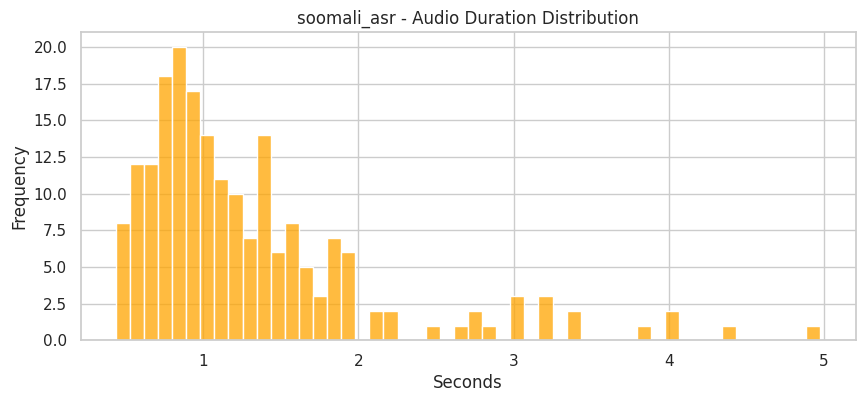

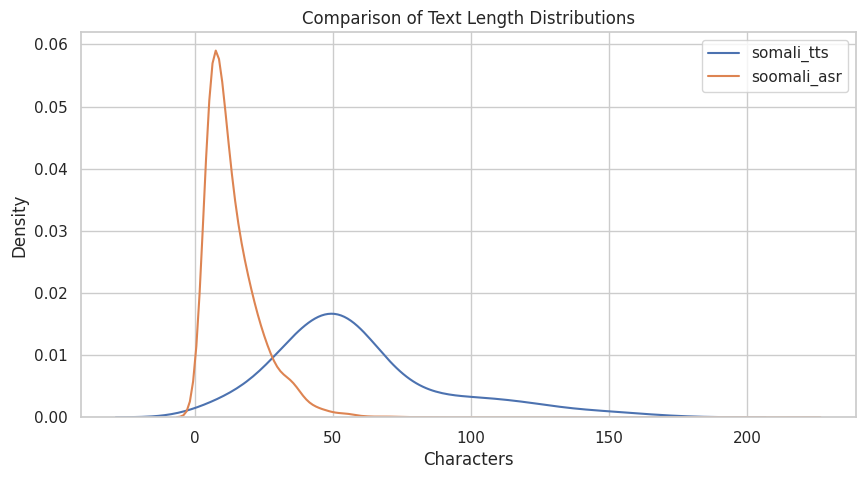

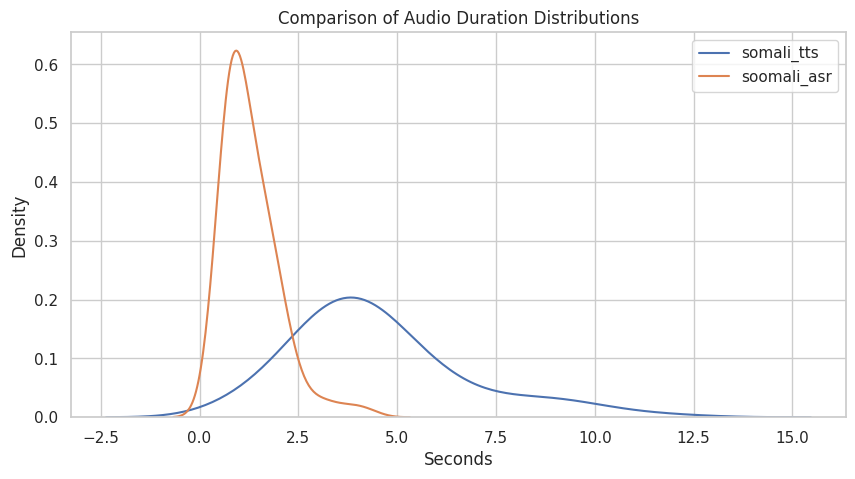

In [1]:
# Optimized EDA for Somali Datasets (Colab-Friendly)

import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import soundfile as sf

# Seaborn style
sns.set(style="whitegrid")

# Base dataset path
BASE_PATH = Path("/content/drive/MyDrive/datasets")

# Datasets
DATASETS = {
    "somali_tts": {
        "csv": BASE_PATH / "somali_tts_dataset.csv",
        "audio_dir": BASE_PATH / "somali_tts_audio"
    },
    "soomali_asr": {
        "csv": BASE_PATH / "soomali_asr_dataset_shortened.csv",
        "audio_dir": BASE_PATH / "soomali_asr_audio"
    }
}

def quick_plot(series, title, xlabel, color="blue", bins=50):
    """Utility to quickly plot distributions."""
    plt.figure(figsize=(10,4))
    sns.histplot(series, bins=bins, kde=False, color=color)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Frequency")
    plt.show()

def analyze_dataset(name, csv_path, audio_dir, num_samples_text=5, max_audio_files=200):
    print(f"\n{'='*60}\nDataset: {name.upper()}\n{'='*60}")

    # Load CSV
    df = pd.read_csv(csv_path)
    print(f"Total samples: {len(df)}")

    # ----- TEXT ANALYSIS -----
    df["text_length"] = df["text"].astype(str).str.len()

    print("\nText length stats:")
    print(df["text_length"].describe())

    quick_plot(df["text_length"], f"{name} - Text Length Distribution", "Characters", color="green")

    # Show random text samples
    print(f"\nSample text entries ({num_samples_text}):")
    print(df["text"].sample(num_samples_text, random_state=42).tolist())

    # ----- AUDIO ANALYSIS -----
    durations, sample_rates = [], []
    missing = 0

    # Randomly sample rows to avoid scanning all files
    sample_df = df.sample(min(max_audio_files, len(df)), random_state=42)

    for file_path in sample_df["file_path"]:
        audio_path = audio_dir / Path(file_path).name
        if not audio_path.exists():
            missing += 1
            continue
        try:
            info = sf.info(audio_path)
            durations.append(info.frames / info.samplerate)
            sample_rates.append(info.samplerate)
        except:
            missing += 1

    print(f"\nAnalyzed {len(durations)} audio files (missing: {missing})")

    if durations:
        dur_series = pd.Series(durations)

        print("\nAudio duration stats (seconds):")
        print(dur_series.describe())

        print("\nSample rate distribution:")
        print(pd.Series(sample_rates).value_counts())

        quick_plot(dur_series, f"{name} - Audio Duration Distribution", "Seconds", color="orange")

    return df

# ---- Run EDA ----
eda_results = {}
for dataset_name, dataset_info in DATASETS.items():
    df = analyze_dataset(
        dataset_name,
        dataset_info["csv"],
        dataset_info["audio_dir"]
    )
    eda_results[dataset_name] = df

# ---- Compare Text Lengths ----
plt.figure(figsize=(10,5))
for dataset_name, df in eda_results.items():
    sns.kdeplot(df["text_length"], label=dataset_name, bw_adjust=1.5)
plt.title("Comparison of Text Length Distributions")
plt.xlabel("Characters")
plt.ylabel("Density")
plt.legend()
plt.show()

# ---- Compare Audio Durations ----
plt.figure(figsize=(10,5))
for dataset_name, dataset_info in DATASETS.items():
    audio_dir = dataset_info["audio_dir"]
    df = eda_results[dataset_name]

    durations = []
    for file_path in df["file_path"].sample(min(300, len(df)), random_state=0):
        audio_path = audio_dir / Path(file_path).name
        if audio_path.exists():
            try:
                info = sf.info(audio_path)
                durations.append(info.frames / info.samplerate)
            except:
                continue

    if durations:
        sns.kdeplot(durations, label=dataset_name, bw_adjust=1.5)

plt.title("Comparison of Audio Duration Distributions")
plt.xlabel("Seconds")
plt.ylabel("Density")
plt.legend()
plt.show()


## LoRa Fine Tune

In [3]:
import os
import torch
import pandas as pd
from datasets import Dataset, Audio
from transformers import (
    WhisperProcessor,
    WhisperForConditionalGeneration,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments
)
from peft import LoraConfig, get_peft_model

# --- CONFIG ---
MODEL_NAME = "openai/whisper-small"
AUDIO_DIR = "/content/drive/MyDrive/datasets/"  # folder containing your audio files
TTS_MANIFEST = "/content/drive/MyDrive/datasets/somali_tts_dataset.csv"
ASR_MANIFEST = "/content/drive/MyDrive/datasets/soomali_asr_dataset_shortened.csv"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
OUTPUT_DIR = "/content/drive/MyDrive/datasets/whisper-lora-trained"

# --- LOAD DATASET (TTS + ASR) ---
df_tts = pd.read_csv(TTS_MANIFEST)
df_asr = pd.read_csv(ASR_MANIFEST)

df = pd.concat([df_tts, df_asr], ignore_index=True)
df["path"] = df["file_path"].apply(lambda x: os.path.join(AUDIO_DIR, x))

dataset = Dataset.from_pandas(df)
dataset = dataset.cast_column("path", Audio(sampling_rate=16000))

# --- LOAD PROCESSOR & MODEL ---
processor = WhisperProcessor.from_pretrained(MODEL_NAME)

# Wrapper to fix forward signature for PEFT
class WhisperForLoRA(WhisperForConditionalGeneration):
    def forward(self, input_features=None, labels=None, **kwargs):
        return super().forward(input_features=input_features, labels=labels)

model = WhisperForLoRA.from_pretrained(MODEL_NAME).to(DEVICE)

# --- FREEZE BASE MODEL ---
for param in model.parameters():
    param.requires_grad = False

# --- APPLY LORA ---
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],  # attention layers
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_2_SEQ_LM"
)
model = get_peft_model(model, lora_config)

# --- PREPROCESS FUNCTION ---
def preprocess(batch):
    audio = batch["path"]
    inputs = processor(audio["array"], sampling_rate=audio["sampling_rate"], return_tensors="pt")
    batch["input_features"] = inputs.input_features.squeeze(0).tolist()
    batch["labels"] = processor.tokenizer(batch["text"]).input_ids
    return batch

dataset = dataset.map(preprocess, remove_columns=["file_path", "text"])

# --- DATA COLLATOR ---
def data_collator(batch):
    input_features = torch.tensor([x["input_features"] for x in batch], dtype=torch.float32)
    labels = processor.tokenizer.pad(
        {"input_ids": [x["labels"] for x in batch]},
        padding=True,
        return_tensors="pt"
    ).input_ids
    return {"input_features": input_features, "labels": labels}

# --- TRAINING ARGUMENTS ---
training_args = Seq2SeqTrainingArguments(
    output_dir=OUTPUT_DIR,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    num_train_epochs=1,
    fp16=True,
    logging_steps=10,
    learning_rate=1e-4,
    save_strategy="steps",
    save_steps=50,
    predict_with_generate=True,
    load_best_model_at_end=False
)

# --- TRAINER ---
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
    eval_dataset=dataset,
    tokenizer=processor.tokenizer,
    data_collator=data_collator
)

# --- TRAIN ---
trainer.train()

# --- SAVE PROCESSOR & MODEL ---
processor.save_pretrained(OUTPUT_DIR)
model.save_pretrained(OUTPUT_DIR)

# --- VERIFY TRAINABLE PARAMETERS ---
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
print(f"Trainable params: {trainable_params} / {total_params} ({trainable_params/total_params*100:.2f}%)")


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/6718 [00:00<?, ? examples/s]

KeyboardInterrupt: 

## Evaluate LoRA Fine Tuned whisper-small on unseen somali data

In [6]:
import torch
import torchaudio
from datasets import load_dataset, Audio
from transformers import WhisperProcessor, WhisperForConditionalGeneration
from peft import PeftModel
from jiwer import wer, cer

# -------- CONFIG ----------
MODEL_DIR = "/content/drive/MyDrive/whisper-lora-trained"   # path to your fine-tuned LoRA model
CHECKPOINT = None  # or "checkpoint-100" if you want a specific one
LANGUAGE = "so"

DATASETS = [
    ("adityaedy01/somali-voice", "sentence"),      # dataset_id, reference column
    ("nurfarah57/somali_asr", "transcription"),
]
BATCH_SIZE = 4
# --------------------------

# Device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device for inference:", DEVICE)

# --- LOAD PROCESSOR & BASE MODEL ---
processor = WhisperProcessor.from_pretrained(MODEL_DIR, language=LANGUAGE, task="transcribe")
base_model = WhisperForConditionalGeneration.from_pretrained(MODEL_DIR).to(DEVICE)

# --- LOAD LO-RA ADAPTER ---
if CHECKPOINT:
    model = PeftModel.from_pretrained(base_model, f"{MODEL_DIR}/{CHECKPOINT}").to(DEVICE)
else:
    model = PeftModel.from_pretrained(base_model, MODEL_DIR).to(DEVICE)

model.eval()

# --- TRANSCRIPTION FUNCTION ---
def generate_transcription(audio_array):
    # Convert audio to processor input
    inputs = processor(audio_array, sampling_rate=16000, return_tensors="pt")
    input_features = inputs.input_features.to(DEVICE)

    forced_decoder_ids = processor.get_decoder_prompt_ids(language=LANGUAGE, task="transcribe")

    with torch.no_grad():
        predicted_ids = model.generate(
            input_features=input_features,        # ✅ keyword arg (not positional!)
            forced_decoder_ids=forced_decoder_ids,
            do_sample=False,
            num_beams=5,
            early_stopping=True,
            num_return_sequences=1,
            max_length=448,
            length_penalty=1.0,
            no_repeat_ngram_size=3,
        )

    transcription = processor.batch_decode(predicted_ids, skip_special_tokens=True)[0]
    return transcription.strip()


# --- EVALUATION FUNCTION ---
def evaluate_dataset(dataset_id: str, text_column: str, batch_size: int):
    print(f"\n=== Loading dataset {dataset_id} ===")
    ds = load_dataset(dataset_id, split="train")
    ds = ds.cast_column("audio", Audio(sampling_rate=16000))

    def transcribe_batch(batch):
        audios = [a["array"] for a in batch["audio"]]
        preds = [generate_transcription(a) for a in audios]
        batch["prediction"] = preds
        return batch

    print("Running transcription...")
    ds = ds.map(transcribe_batch, batched=True, batch_size=batch_size)

    refs = [str(t).lower().strip() for t in ds[text_column]]
    hyps = [t.lower().strip() for t in ds["prediction"]]

    dataset_wer = wer(refs, hyps)
    dataset_cer = cer(refs, hyps)

    print("\n=== Results for", dataset_id, "===")
    print("Samples evaluated:", len(refs))
    print("WER:", dataset_wer)
    print("CER:", dataset_cer)

    print("\n=== Example Transcriptions ===")
    for i, (r, h) in enumerate(zip(refs, hyps[:10])):  # show only first 10
        print(f"[{i+1}] REF: {r}")
        print(f"    HYP: {h}")
        print("    ---")

    return {"refs": refs, "hyps": hyps, "wer": dataset_wer, "cer": dataset_cer}


# ---- Run evaluation ----
results = {}
for ds_id, text_col in DATASETS:
    results[ds_id] = evaluate_dataset(ds_id, text_col, batch_size=BATCH_SIZE)


Device for inference: cuda


/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:196: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(



=== Loading dataset adityaedy01/somali-voice ===
Running transcription...


Map:   0%|          | 0/2 [00:00<?, ? examples/s]

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.



=== Results for adityaedy01/somali-voice ===
Samples evaluated: 2
WER: 0.18181818181818182
CER: 0.03333333333333333

=== Example Transcriptions ===
[1] REF: geed gaab iyo geed qodaxeed
    HYP: geed qaab iyo geed qodaheed
    ---
[2] REF: laba iyo lixdan laxaad oo dhalaya
    HYP: laba iyo lixdan laxaad oo dhalaya
    ---

=== Loading dataset nurfarah57/somali_asr ===
Running transcription...


Map:   0%|          | 0/3 [00:00<?, ? examples/s]


=== Results for nurfarah57/somali_asr ===
Samples evaluated: 3
WER: 0.7777777777777778
CER: 0.24528301886792453

=== Example Transcriptions ===
[1] REF: geelka waa jaalo.
    HYP: ديلka waa jaalo
    ---
[2] REF: geedkaas waa qurac.
    HYP: qeedkaas waa quraq
    ---
[3] REF: lis caanaha geel.
    HYP: ليs caanah geed
    ---
